In [6]:
# Sky plot for Ariel targets (RA/Dec) — nicer Aitoff projection
# - color = distance (pc) on a log scale
# - marker size ~ 1/sqrt(distance)
# - labels only for the N nearest targets (to avoid clutter)
#
# Works with your file: Ariel_MCS_Known_2024-07-09.csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_targets_sky(
    csv_path: str,
    out_path: str = "ariel_targets_sky_aitoff_pretty.pdf",
    label_n: int = 20,
    min_alpha: float = 0.55,
):
    df = pd.read_csv(csv_path)

    # required columns in your file
    ra = pd.to_numeric(df["Star RA"], errors="coerce").to_numpy(float)   # deg, 0..360
    dec = pd.to_numeric(df["Star Dec"], errors="coerce").to_numpy(float) # deg, -90..90
    dist = pd.to_numeric(df.get("Star Distance [pc]"), errors="coerce").to_numpy(float)
    name = df["Planet Name"].astype(str).to_numpy()

    m = np.isfinite(ra) & np.isfinite(dec)
    ra, dec, dist, name = ra[m], dec[m], dist[m], name[m]

    # --- Aitoff needs longitude in radians in [-pi, +pi] and latitude in radians ---
    # Wrap RA so that 0h (0 deg) is centered. Matplotlib's Aitoff uses lon=0 at center.
    lon_deg = ((ra + 180.0) % 360.0) - 180.0
    lon = np.deg2rad(lon_deg)
    lat = np.deg2rad(dec)

    # --- marker sizes ~ 1/sqrt(dist); handle missing dist gracefully ---
    sizes = np.full(lon.shape, 16.0, dtype=float)
    okd = np.isfinite(dist) & (dist > 0)
    if np.any(okd):
        s = np.zeros_like(dist, dtype=float)
        s[okd] = 1.0 / np.sqrt(dist[okd])
        s[okd] = (s[okd] / np.max(s[okd]))  # 0..1
        sizes = 10.0 + 70.0 * s  # 10..80

    # --- color by distance (log), fallback constant if missing ---
    # Using a log scale makes near vs far readable.
    c = np.full(lon.shape, np.nan, dtype=float)
    if np.any(okd):
        c[okd] = np.log10(dist[okd])
        vmin = np.nanpercentile(c[okd], 1)
        vmax = np.nanpercentile(c[okd], 99)
    else:
        vmin, vmax = 0.0, 1.0

    # --- figure styling ---
    fig = plt.figure(figsize=(13.5, 6.8))
    ax = fig.add_subplot(111, projection="aitoff")

    # subtle background + grid
    ax.set_facecolor((0.98, 0.98, 0.99))
    ax.grid(True, linewidth=0.6, alpha=0.35)

    # scatter: a little edge helps points pop on dense regions
    sc = ax.scatter(
        lon, lat,
        s=sizes,
        c=c,
        vmin=vmin, vmax=vmax,
        alpha=min_alpha,
        linewidths=0.25,
        edgecolors="k",
    )

    # nicer tick labels (RA hours) for an Aitoff sky map
    xticks_deg = np.array([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
    ax.set_xticks(np.deg2rad(xticks_deg))
    # Convert degrees to hours with the wrap we used (center=0deg)
    # lon_deg = ra-180..+180 so label in "hours" around 0
    # For readability: label in hours from -10h..+10h
    xticks_hours = (xticks_deg / 15.0).astype(int)
    ax.set_xticklabels([f"{h}h" if h != 0 else "0h" for h in xticks_hours])

    # label only the nearest label_n by distance (if distances exist),
    # otherwise label first label_n
    if np.any(okd):
        idx = np.argsort(dist, kind="mergesort")[:label_n]
    else:
        idx = np.arange(min(label_n, len(name)))

    for i in idx:
        ax.annotate(
            name[i],
            (lon[i], lat[i]),
            fontsize=8,
            xytext=(3, 3),
            textcoords="offset points",
            bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.65),
        )

    title = "Ariel MCS Known Targets on the Sky (Equatorial Aitoff Projection)"
    ax.set_title(f"{title}", pad=18)

    # colorbar if distances exist
    if np.any(okd):
        cbar = fig.colorbar(sc, ax=ax, orientation="horizontal", pad=0.08, fraction=0.05)
        cbar.set_label("log10(distance [pc])")

    plt.tight_layout()
    plt.savefig(out_path, dpi=250, bbox_inches="tight")
    plt.close(fig)
    print(f"saved: {out_path}")

# Example usage:
plot_targets_sky(
    csv_path="Ariel_MCS_Known_2024-07-09.csv",
    out_path="ariel_targets_sky_aitoff_pretty.pdf",
    label_n=20,
)


saved: ariel_targets_sky_aitoff_pretty.pdf


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Physics helpers (ESM)
# =========================
def planck_ratio_at_lambda(T_num, T_den, lam_um=7.5):
    """
    Returns B_lambda(T_num)/B_lambda(T_den) at wavelength lam_um.
    Constants cancel in the ratio, so this is stable and fast.
    """
    T_num = np.asarray(T_num, dtype=float)
    T_den = np.asarray(T_den, dtype=float)

    lam_m = lam_um * 1e-6
    h = 6.62607015e-34
    c = 299792458.0
    k = 1.380649e-23

    x_num = (h * c) / (lam_m * k * T_num)
    x_den = (h * c) / (lam_m * k * T_den)

    # Bλ ∝ 1/(exp(x)-1) so ratio = (exp(x_den)-1)/(exp(x_num)-1)
    return np.expm1(x_den) / np.expm1(x_num)


# =========================
# Metrics
# =========================
def compute_tsm(df: pd.DataFrame) -> np.ndarray:
    """
    TSM = scale * (Rp^3 * Teq)/(Mp * Rs^2) * 10^(-mJ/5)

    Uses:
      Rp = Planet Radius [Re]
      Mp = Planet Mass [Me]
      Rs = Star Radius [Rs]
      Teq = Planet Temperature [K]
      mJ = Star J Mag
    """
    rp = pd.to_numeric(df["Planet Radius [Re]"], errors="coerce").to_numpy(float)
    mp = pd.to_numeric(df["Planet Mass [Me]"], errors="coerce").to_numpy(float)
    rs = pd.to_numeric(df["Star Radius [Rs]"], errors="coerce").to_numpy(float)
    teq = pd.to_numeric(df["Planet Temperature [K]"], errors="coerce").to_numpy(float)
    mj  = pd.to_numeric(df["Star J Mag"], errors="coerce").to_numpy(float)

    # Standard Kempton-style scale factors by Rp bin
    scale = np.full(rp.shape, np.nan, dtype=float)
    scale[(rp > 0) & (rp < 1.5)] = 0.190
    scale[(rp >= 1.5) & (rp < 2.75)] = 1.26
    scale[(rp >= 2.75) & (rp < 4.0)] = 1.28
    scale[(rp >= 4.0) & (rp < 10.0)] = 1.15

    tsm = scale * (rp**3 * teq) / (mp * rs**2) * 10**(-mj/5.0)
    tsm[~np.isfinite(tsm) | (tsm <= 0)] = np.nan
    return tsm


def compute_esm(df: pd.DataFrame) -> np.ndarray:
    """
    ESM = 4.29e6 * [B_7.5(Tday)/B_7.5(Tstar)] * (Rp/Rs)^2 * 10^(-mK/5)

    Uses:
      Rp = Planet Radius [Rjup]
      Rs = Star Radius [Rs] (converted to Rjup internally)
      Tstar = Star Temperature [K]
      Tday preference:
          Planet Eclipse Temperature [K] if available
          else Planet Temperature [K]
          else 1.1 * Planet Temperature [K]
      mK = Star Ks Mag
    """
    rp_rj = pd.to_numeric(df["Planet Radius [Rjup]"], errors="coerce").to_numpy(float)
    rs_rsun = pd.to_numeric(df["Star Radius [Rs]"], errors="coerce").to_numpy(float)
    tstar = pd.to_numeric(df["Star Temperature [K]"], errors="coerce").to_numpy(float)

    teq  = pd.to_numeric(df["Planet Temperature [K]"], errors="coerce").to_numpy(float)
    tday = pd.to_numeric(df["Planet Eclipse Temperature [K]"], errors="coerce").to_numpy(float)
    tday = np.where(np.isfinite(tday), tday, teq)
    tday = np.where(np.isfinite(tday), tday, 1.1 * teq)

    mk = pd.to_numeric(df["Star Ks Mag"], errors="coerce").to_numpy(float)

    # Convert Rsun -> Rjup
    R_sun_over_R_jup = 9.73116
    rs_rj = rs_rsun * R_sun_over_R_jup

    bratio = planck_ratio_at_lambda(tday, tstar, lam_um=7.5)
    esm = 4.29e6 * bratio * (rp_rj / rs_rj)**2 * 10**(-mk/5.0)

    esm[~np.isfinite(esm) | (esm <= 0)] = np.nan
    return esm


# =========================
# Sky plot helper
# =========================
def sky_aitoff(df, color_col, size_col, out_path, label_n=15, title=""):
    ra = pd.to_numeric(df["Star RA"], errors="coerce").to_numpy(float)
    dec = pd.to_numeric(df["Star Dec"], errors="coerce").to_numpy(float)
    planet = df["Planet Name"].astype(str).to_numpy()

    color = pd.to_numeric(df[color_col], errors="coerce").to_numpy(float)
    sizev = pd.to_numeric(df[size_col], errors="coerce").to_numpy(float)

    # require finite and positive for log scaling
    m = (
        np.isfinite(ra) & np.isfinite(dec) &
        np.isfinite(color) & (color > 0) &
        np.isfinite(sizev) & (sizev > 0)
    )
    ra, dec, planet, color, sizev = ra[m], dec[m], planet[m], color[m], sizev[m]

    # Aitoff expects lon in [-pi,pi]
    lon_deg = ((ra + 180) % 360) - 180
    lon = np.deg2rad(lon_deg)
    lat = np.deg2rad(dec)

    # encodings
    c = np.log10(color)
    s = np.log10(sizev)

    # robust size mapping
    s_norm = (s - np.nanpercentile(s, 2)) / (np.nanpercentile(s, 98) - np.nanpercentile(s, 2) + 1e-12)
    s_norm = np.clip(s_norm, 0, 1)
    sizes = 12 + 95 * s_norm

    fig = plt.figure(figsize=(13.5, 6.8))
    ax = fig.add_subplot(111, projection="aitoff")
    ax.set_facecolor((0.98, 0.98, 0.99))
    ax.grid(True, linewidth=0.6, alpha=0.35)

    sc = ax.scatter(
        lon, lat,
        s=sizes,
        c=c,
        alpha=0.78,
        linewidths=0.25,
        edgecolors="k",
    )

    # RA hour ticks
    xticks_deg = np.array([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
    ax.set_xticks(np.deg2rad(xticks_deg))
    ax.set_xticklabels([f"{int(d/15)}h" if d != 0 else "0h" for d in xticks_deg])

    # label “best” by combined strength in both metrics (log product)
    score = np.log10(color) + np.log10(sizev)
    idx = np.argsort(score)[::-1][:min(label_n, len(score))]
    for i in idx:
        ax.annotate(
            planet[i],
            (lon[i], lat[i]),
            fontsize=8,
            xytext=(3, 3),
            textcoords="offset points",
            bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.65),
        )

    ax.set_title(title, pad=18)
    cbar = fig.colorbar(sc, ax=ax, orientation="horizontal", pad=0.08, fraction=0.05)
    cbar.set_label(f"log10({color_col})  (color)")

    ax.text(0.02, -0.10, f"marker size ∝ log10({size_col})", transform=ax.transAxes, fontsize=9)

    plt.tight_layout()
    plt.savefig(out_path, dpi=250, bbox_inches="tight")
    plt.close(fig)


# =========================
# Run
# =========================
csv_path = "Ariel_MCS_Known_2024-07-09.csv"
df = pd.read_csv(csv_path)

df["TSM"] = compute_tsm(df)
df["ESM"] = compute_esm(df)

# Sky maps
sky_aitoff(
    df, "TSM", "ESM",
    out_path="ariel_sky_TSM_color_ESM_size.pdf",
    label_n=18,
    title="Ariel Known Targets: sky map (color = log10(TSM), size = log10(ESM))",
)

sky_aitoff(
    df, "ESM", "TSM",
    out_path="ariel_sky_ESM_color_TSM_size.pdf",
    label_n=18,
    title="Ariel Known Targets: sky map (color = log10(ESM), size = log10(TSM))",
)

# ESM vs TSM scatter
m = np.isfinite(df["TSM"]) & (df["TSM"] > 0) & np.isfinite(df["ESM"]) & (df["ESM"] > 0)
tsm = df.loc[m, "TSM"].to_numpy(float)
esm = df.loc[m, "ESM"].to_numpy(float)

plt.figure(figsize=(7.2, 6.2))
plt.scatter(np.log10(tsm), np.log10(esm), alpha=0.7, linewidths=0.25, edgecolors="k")
plt.xlabel("log10(TSM)")
plt.ylabel("log10(ESM)")
plt.title("Ariel Known Targets: ESM vs TSM (log–log)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("ariel_ESM_vs_TSM.pdf", dpi=250, bbox_inches="tight")
plt.close()

print("Saved: ariel_sky_TSM_color_ESM_size.pdf")
print("Saved: ariel_sky_ESM_color_TSM_size.pdf")
print("Saved: ariel_ESM_vs_TSM.pdf")


/var/folders/3w/spgmt8fj0t96y3xgc31682jm0000gn/T/ipykernel_9981/3151982947.py:21: RuntimeWarning: divide by zero encountered in divide
  x_num = (h * c) / (lam_m * k * T_num)


Saved: ariel_sky_TSM_color_ESM_size.pdf
Saved: ariel_sky_ESM_color_TSM_size.pdf
Saved: ariel_ESM_vs_TSM.pdf


In [8]:
"""
Ariel Known targets: compute TSM/ESM (using Teq from geometry), then make:
  1) Sky Aitoff map (color = TSM, size = ESM)  [log toggle]
  2) Sky Aitoff map (color = ESM, size = TSM)  [log toggle]
  3) ESM vs TSM scatter (+ optional colorbar metric)  [log toggle]
  4) Rp histogram (Number vs Rp) for Ariel Known (like the Ariel figure)

Notes:
- Teq is computed from: Teq = T_star * sqrt(R_star/(2a))  (A=0, full redistribution)
- No seaborn; matplotlib only.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# -------------------------
# Plot styling (prettier)
# -------------------------
def set_pretty_rcparams():
    plt.rcParams.update({
        "figure.dpi": 120,
        "savefig.dpi": 250,
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 13,
        "axes.linewidth": 1.0,
        "xtick.major.width": 1.0,
        "ytick.major.width": 1.0,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "grid.alpha": 0.25,
        "grid.linewidth": 0.8,
    })

set_pretty_rcparams()



def compute_teq_geom(df: pd.DataFrame) -> np.ndarray:
    """
    Teq = T_star * sqrt(R_star/(2a))  (A=0, full redistribution)

    Requires columns:
      - Star Temperature [K]
      - Star Radius [Rs]            (R_sun)
      - Planet Semi-major Axis [au] (AU)
    """
    tstar = pd.to_numeric(df["Star Temperature [K]"], errors="coerce").to_numpy(float)
    rstar_rsun = pd.to_numeric(df["Star Radius [Rs]"], errors="coerce").to_numpy(float)
    a_au = pd.to_numeric(df["Planet Semi-major Axis [au]"], errors="coerce").to_numpy(float)

    R_SUN_M = 6.957e8
    AU_M = 1.495978707e11

    rstar_m = rstar_rsun * R_SUN_M
    a_m = a_au * AU_M

    teq = tstar * np.sqrt(rstar_m / (2.0 * a_m))
    teq[~np.isfinite(teq) | (teq <= 0)] = np.nan
    return teq


#  For ESM

def planck_ratio_at_lambda(T_num, T_den, lam_um=7.5):
    """
    B_lambda(T_num) / B_lambda(T_den) at lam_um.
    """
    T_num = np.asarray(T_num, dtype=float)
    T_den = np.asarray(T_den, dtype=float)

    lam_m = lam_um * 1e-6
    h = 6.62607015e-34
    c = 299792458.0
    k = 1.380649e-23

    x_num = (h * c) / (lam_m * k * T_num)
    x_den = (h * c) / (lam_m * k * T_den)
    return np.expm1(x_den) / np.expm1(x_num)


# Metrics (TSM uses Teq_geom)

def compute_tsm(df: pd.DataFrame, teq: np.ndarray) -> np.ndarray:
    """
    TSM = scale * (Rp^3 * Teq)/(Mp * Rs^2) * 10^(-mJ/5)

    Uses:
      Rp = Planet Radius [Re]
      Mp = Planet Mass [Me]
      Rs = Star Radius [Rs]
      mJ = Star J Mag
    """
    rp = pd.to_numeric(df["Planet Radius [Re]"], errors="coerce").to_numpy(float)
    mp = pd.to_numeric(df["Planet Mass [Me]"], errors="coerce").to_numpy(float)
    rs = pd.to_numeric(df["Star Radius [Rs]"], errors="coerce").to_numpy(float)
    mj = pd.to_numeric(df["Star J Mag"], errors="coerce").to_numpy(float)

    # Kempton-style scale factors by Rp bin
    scale = np.full(rp.shape, np.nan, dtype=float)
    scale[(rp > 0) & (rp < 1.5)] = 0.190
    scale[(rp >= 1.5) & (rp < 2.75)] = 1.26
    scale[(rp >= 2.75) & (rp < 4.0)] = 1.28
    scale[(rp >= 4.0) & (rp < 10.0)] = 1.15

    tsm = scale * (rp**3 * teq) / (mp * rs**2) * 10**(-mj/5.0)
    tsm[~np.isfinite(tsm) | (tsm <= 0)] = np.nan
    return tsm


def compute_esm(df: pd.DataFrame, tday_mode: str = "eclipse_or_teq") -> np.ndarray:
    """
    ESM = 4.29e6 * [B_7.5(Tday)/B_7.5(Tstar)] * (Rp/Rs)^2 * 10^(-mK/5)

    tday_mode:
      - "eclipse_or_teq": prefer Planet Eclipse Temperature [K], else Teq_geom, else Planet Temperature [K]
      - "teq_only": use Teq_geom only
      - "csv_only": use Planet Eclipse Temperature [K] else Planet Temperature [K]
    """
    rp_rj = pd.to_numeric(df["Planet Radius [Rjup]"], errors="coerce").to_numpy(float)
    rs_rsun = pd.to_numeric(df["Star Radius [Rs]"], errors="coerce").to_numpy(float)
    tstar = pd.to_numeric(df["Star Temperature [K]"], errors="coerce").to_numpy(float)
    mk = pd.to_numeric(df["Star Ks Mag"], errors="coerce").to_numpy(float)

    teq_geom = compute_teq_geom(df)
    teq_csv = pd.to_numeric(df.get("Planet Temperature [K]"), errors="coerce").to_numpy(float)
    teclipse = pd.to_numeric(df.get("Planet Eclipse Temperature [K]"), errors="coerce").to_numpy(float)

    if tday_mode == "teq_only":
        tday = teq_geom
    elif tday_mode == "csv_only":
        tday = np.where(np.isfinite(teclipse), teclipse, teq_csv)
    else:
        # eclipse first; then Teq_geom; then csv Teq; then 1.1*csv Teq
        tday = np.where(np.isfinite(teclipse), teclipse, teq_geom)
        tday = np.where(np.isfinite(tday), tday, teq_csv)
        tday = np.where(np.isfinite(tday), tday, 1.1 * teq_csv)

    # Convert Rsun -> Rjup
    R_SUN_OVER_R_JUP = 9.73116
    rs_rj = rs_rsun * R_SUN_OVER_R_JUP

    bratio = planck_ratio_at_lambda(tday, tstar, lam_um=7.5)
    esm = 4.29e6 * bratio * (rp_rj / rs_rj) ** 2 * 10 ** (-mk / 5.0)

    esm[~np.isfinite(esm) | (esm <= 0)] = np.nan
    return esm



# Utility: robust scaling
def robust_limits(x, lo=1, hi=99):
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return (0.0, 1.0)
    return (np.percentile(x, lo), np.percentile(x, hi))


# =========================
# 1–2) Sky Aitoff maps
# =========================
def sky_aitoff(
    df: pd.DataFrame,
    color_col: str,
    size_col: str,
    out_path: str,
    title: str,
    label_n: int = 18,
    use_log: bool = False,
):
    ra = pd.to_numeric(df["Star RA"], errors="coerce").to_numpy(float)
    dec = pd.to_numeric(df["Star Dec"], errors="coerce").to_numpy(float)
    planet = df["Planet Name"].astype(str).to_numpy()

    color = pd.to_numeric(df[color_col], errors="coerce").to_numpy(float)
    sizev = pd.to_numeric(df[size_col], errors="coerce").to_numpy(float)

    m = np.isfinite(ra) & np.isfinite(dec) & np.isfinite(color) & (color > 0) & np.isfinite(sizev) & (sizev > 0)
    ra, dec, planet, color, sizev = ra[m], dec[m], planet[m], color[m], sizev[m]

    # Aitoff coords
    lon_deg = ((ra + 180) % 360) - 180
    lon = np.deg2rad(lon_deg)
    lat = np.deg2rad(dec)

    # Choose mapping
    if use_log:
        c = np.log10(color)
        sv = np.log10(sizev)
        c_label = f"log10({color_col})"
        s_label = f"log10({size_col})"
    else:
        c = color
        sv = sizev
        c_label = f"{color_col}"
        s_label = f"{size_col}"

    # Size mapping (robust)
    s_lo, s_hi = robust_limits(sv, 2, 98)
    sv_clip = np.clip(sv, s_lo, s_hi)
    s_norm = (sv_clip - s_lo) / (s_hi - s_lo + 1e-12)
    sizes = 14 + 90 * s_norm

    # Color limits (robust)
    vmin, vmax = robust_limits(c, 1, 99)

    fig = plt.figure(figsize=(13.8, 7.0))
    ax = fig.add_subplot(111, projection="aitoff")
    ax.set_facecolor((0.98, 0.98, 0.99))
    ax.grid(True)

    sc = ax.scatter(
        lon, lat,
        s=sizes,
        c=c,
        vmin=vmin, vmax=vmax,
        alpha=0.80,
        linewidths=0.25,
        edgecolors="k",
    )

    # RA ticks in hours
    xticks_deg = np.array([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
    ax.set_xticks(np.deg2rad(xticks_deg))
    ax.set_xticklabels([f"{int(d/15)}h" if d != 0 else "0h" for d in xticks_deg])

    # Label "best" by product (or log-product)
    score = (np.log10(color) + np.log10(sizev)) if use_log else (color * sizev)
    idx = np.argsort(score)[::-1][:min(label_n, score.size)]
    for i in idx:
        ax.annotate(
            planet[i],
            (lon[i], lat[i]),
            fontsize=8,
            xytext=(3, 3),
            textcoords="offset points",
            bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.70),
        )

    ax.set_title(title, pad=18)
    cbar = fig.colorbar(sc, ax=ax, orientation="horizontal", pad=0.08, fraction=0.05)
    cbar.set_label(f"{c_label} (color)")

    ax.text(0.02, -0.10, f"marker size ∝ {s_label}", transform=ax.transAxes, fontsize=10)

    plt.tight_layout()
    plt.savefig(out_path, bbox_inches="tight")
    plt.close(fig)


# =========================
# 3) ESM vs TSM scatter (+ optional colorbar)
# =========================
def esm_tsm_scatter(
    df: pd.DataFrame,
    out_path: str,
    use_log: bool = True,
    color_by: str | None = "Planet Radius [Re]",
    title: str = "Ariel Known Targets: ESM vs TSM",
):
    esm = pd.to_numeric(df["ESM"], errors="coerce").to_numpy(float)
    tsm = pd.to_numeric(df["TSM"], errors="coerce").to_numpy(float)

    m = np.isfinite(esm) & (esm > 0) & np.isfinite(tsm) & (tsm > 0)
    esm, tsm = esm[m], tsm[m]

    if use_log:
        x = np.log10(tsm)
        y = np.log10(esm)
        xlabel, ylabel = "log10(TSM)", "log10(ESM)"
    else:
        x, y = tsm, esm
        xlabel, ylabel = "TSM", "ESM"

    # optional colorbar metric (useful choices: Rp, Teq_geom [K], Star Distance [pc], Star J Mag, etc.)
    c = None
    c_label = None
    if color_by is not None and color_by in df.columns:
        c_all = pd.to_numeric(df[color_by], errors="coerce").to_numpy(float)
        c = c_all[m]
        c_label = color_by

    fig = plt.figure(figsize=(7.8, 6.6))
    ax = fig.add_subplot(111)
    ax.grid(True)

    if c is None:
        sc = ax.scatter(x, y, alpha=0.78, linewidths=0.25, edgecolors="k")
    else:
        vmin, vmax = robust_limits(c, 2, 98)
        sc = ax.scatter(x, y, c=c, vmin=vmin, vmax=vmax, alpha=0.82, linewidths=0.25, edgecolors="k")
        cbar = fig.colorbar(sc, ax=ax, pad=0.02)
        cbar.set_label(c_label)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"{title}{' (log-log)' if use_log else ''}")

    plt.tight_layout()
    plt.savefig(out_path, bbox_inches="tight")
    plt.close(fig)


# =========================
# 4) Rp histogram (Ariel Known only)
# =========================
def rp_histogram_known(
    df: pd.DataFrame,
    out_path: str,
    bins: np.ndarray | None = None,
    title: str = "Ariel Known Targets: Planet Radius Distribution",
):
    rp = pd.to_numeric(df["Planet Radius [Re]"], errors="coerce").to_numpy(float)
    rp = rp[np.isfinite(rp) & (rp > 0)]

    if bins is None:
        # Similar feel to Ariel plots: fine bins up to 10, plus an overflow bin >10
        bins = np.r_[np.linspace(0, 10, 11), np.inf]  # 0-1-...-10, then >10

    counts, edges = np.histogram(rp, bins=bins)
    centers = 0.5 * (edges[:-1] + np.where(np.isfinite(edges[1:]), edges[1:], edges[:-1] + 1.0))

    fig = plt.figure(figsize=(7.8, 5.6))
    ax = fig.add_subplot(111)
    ax.grid(True, axis="y")

    # Step-style histogram (publication-y)
    ax.step(edges[:-1], np.r_[counts, counts[-1]][:-1], where="post", linewidth=2.0)

    ax.set_xlabel(r"$R_p\ [R_{\oplus}]$")
    ax.set_ylabel("Number")
    ax.set_title(title)

    # Nice integer y ticks
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Annotate N
    ax.text(
        0.04, 0.92,
        f"N = {rp.size} planets",
        transform=ax.transAxes,
        fontsize=13,
        va="top"
    )

    # Mark overflow bin if present
    if np.isinf(edges[-1]):
        ax.axvline(10, linewidth=1.5)
        ax.text(10.15, ax.get_ylim()[1]*0.75, r"$R_p > 10\,R_{\oplus}$", rotation=90, va="center")

    plt.tight_layout()
    plt.savefig(out_path, bbox_inches="tight")
    plt.close(fig)


# =========================
# Main runner
# =========================
def make_all_plots(
    csv_path: str = "Ariel_MCS_Known_2024-07-09.csv",
    use_log_all: bool = False,          # <-- master toggle for sky+scatter
    scatter_use_log: bool | None = None,
    sky_use_log: bool | None = None,
    colorbar_metric: str = "Planet Radius [Re]",  # good default
):
    df = pd.read_csv(csv_path)

    # Teq from your equation
    df["Teq_geom [K]"] = compute_teq_geom(df)

    # Metrics
    df["TSM"] = compute_tsm(df, df["Teq_geom [K]"].to_numpy(float))
    df["ESM"] = compute_esm(df, tday_mode="eclipse_or_teq")

    if scatter_use_log is None:
        scatter_use_log = use_log_all
    if sky_use_log is None:
        sky_use_log = use_log_all

    # Sky maps
    sky_aitoff(
        df, "TSM", "ESM",
        out_path="ariel_sky_TSM_color_ESM_size.pdf",
        label_n=18,
        use_log=sky_use_log,
        title=f"Ariel Known Targets: sky map (color=TSM, size=ESM){' [log]' if sky_use_log else ''}",
    )

    sky_aitoff(
        df, "ESM", "TSM",
        out_path="ariel_sky_ESM_color_TSM_size.pdf",
        label_n=18,
        use_log=sky_use_log,
        title=f"Ariel Known Targets: sky map (color=ESM, size=TSM){' [log]' if sky_use_log else ''}",
    )

    # ESM vs TSM scatter with a useful colorbar
    # (try: "Planet Radius [Re]" or "Teq_geom [K]" or "Star Distance [pc]" or "Star J Mag")
    esm_tsm_scatter(
        df,
        out_path="ariel_ESM_vs_TSM.pdf",
        use_log=scatter_use_log,
        color_by=colorbar_metric,
        title="Ariel Known Targets: ESM vs TSM",
    )

    # Rp histogram (Ariel known only)
    rp_histogram_known(
        df,
        out_path="ariel_known_Rp_hist.pdf",
        title="Ariel Known Targets: Planet Radius Distribution",
    )

    print("Saved: ariel_sky_TSM_color_ESM_size.pdf")
    print("Saved: ariel_sky_ESM_color_TSM_size.pdf")
    print("Saved: ariel_ESM_vs_TSM.pdf")
    print("Saved: ariel_known_Rp_hist.pdf")


make_all_plots(
    csv_path="Ariel_MCS_Known_2024-07-09.csv",
    use_log_all=False,
    colorbar_metric="Planet Radius [Re]",
)

# 2) Turn logs on everywhere (often more informative for ESM/TSM)
# make_all_plots(
#     csv_path="Ariel_MCS_Known_2024-07-09.csv",
#     use_log_all=True,
#     colorbar_metric="Teq_geom [K]",
# )


/var/folders/3w/spgmt8fj0t96y3xgc31682jm0000gn/T/ipykernel_9981/190493122.py:79: RuntimeWarning: divide by zero encountered in divide
  x_num = (h * c) / (lam_m * k * T_num)


Saved: ariel_sky_TSM_color_ESM_size.pdf
Saved: ariel_sky_ESM_color_TSM_size.pdf
Saved: ariel_ESM_vs_TSM.pdf
Saved: ariel_known_Rp_hist.pdf


In [9]:
def rp_hist_logy(df, out_path="ariel_known_Rp_hist_logy.pdf", rmax=25, binw=0.5):
    rp = pd.to_numeric(df["Planet Radius [Re]"], errors="coerce").to_numpy(float)
    rp = rp[np.isfinite(rp) & (rp > 0)]

    bins = np.arange(0, rmax + binw, binw)

    plt.figure(figsize=(9, 5.8))
    plt.hist(rp[rp < rmax], bins=bins, histtype="step", linewidth=2.2)
    plt.yscale("log")
    plt.xlabel(r"$R_p\ [R_{\oplus}]$")
    plt.ylabel("Number (log scale)")
    plt.title("Ariel Known Targets: Planet Radius Distribution (log-y)")
    plt.grid(True, which="both", axis="y", alpha=0.25)

    n_over = np.sum(rp >= rmax)
    if n_over > 0:
        plt.text(0.98, 0.95, f"{n_over} planets with $R_p\\geq {rmax}$ not shown",
                 transform=plt.gca().transAxes, ha="right", va="top")

    plt.tight_layout()
    plt.savefig(out_path, dpi=250, bbox_inches="tight")
    plt.close()
    print("Saved:", out_path)

df = pd.read_csv("Ariel_MCS_Known_2024-07-09.csv")
rp_hist_logy(df)

Saved: ariel_known_Rp_hist_logy.pdf


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def rp_hist_two_panel(
    df: pd.DataFrame,
    out_path="ariel_known_Rp_hist_two_panel.png",
    r_small_max=10.0,
    r_big_max=25.0,
    bin_small=0.5,
    bin_big=0.5,
):
    rp = pd.to_numeric(df["Planet Radius [Re]"], errors="coerce").to_numpy(float)
    rp = rp[np.isfinite(rp) & (rp > 0)]

    bins_small = np.arange(0, r_small_max + bin_small, bin_small)
    bins_big   = np.arange(r_small_max, r_big_max + bin_big, bin_big)

    fig = plt.figure(figsize=(9.2, 7.2))
    gs = fig.add_gridspec(2, 1, height_ratios=[3, 2], hspace=0.06)

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=None)

    # small planets
    ax1.hist(rp[rp < r_small_max], bins=bins_small, histtype="step", linewidth=2.2)
    ax1.set_xlim(0, r_small_max)
    ax1.set_ylabel("Number")
    ax1.grid(True, axis="y", alpha=0.25)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_title("Ariel Known Targets: Planet Radius Distribution (split to avoid >10 R⊕ dominance)")

    # giants
    ax2.hist(rp[(rp >= r_small_max) & (rp < r_big_max)], bins=bins_big, histtype="step", linewidth=2.2)
    ax2.set_xlim(r_small_max, r_big_max)
    ax2.set_xlabel(r"$R_p\ [R_{\oplus}]$")
    ax2.set_ylabel("Number")
    ax2.grid(True, axis="y", alpha=0.25)
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

    # annotate counts
    n_total = rp.size
    n_small = np.sum(rp < r_small_max)
    n_big   = np.sum((rp >= r_small_max) & (rp < r_big_max))
    n_very_big = np.sum(rp >= r_big_max)

    ax1.text(0.02, 0.92, f"N = {n_total}", transform=ax1.transAxes, fontsize=13, va="top")
    ax1.text(0.02, 0.84, f"< {r_small_max:g} R⊕ : {n_small}", transform=ax1.transAxes, fontsize=11, va="top")
    ax1.text(0.02, 0.76, f"{r_small_max:g}–{r_big_max:g} R⊕ : {n_big}", transform=ax1.transAxes, fontsize=11, va="top")
    if n_very_big > 0:
        ax1.text(0.02, 0.68, f"≥ {r_big_max:g} R⊕ : {n_very_big} (not shown)", transform=ax1.transAxes, fontsize=11, va="top")

    plt.tight_layout()
    plt.savefig(out_path, dpi=250, bbox_inches="tight")
    plt.close(fig)
    print("Saved:", out_path)

# usage
df = pd.read_csv("Ariel_MCS_Known_2024-07-09.csv")
rp_hist_two_panel(df)


Saved: ariel_known_Rp_hist_two_panel.png


/var/folders/3w/spgmt8fj0t96y3xgc31682jm0000gn/T/ipykernel_9981/693784899.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


AttributeError: module 'matplotlib.pyplot' has no attribute 'transAxes'

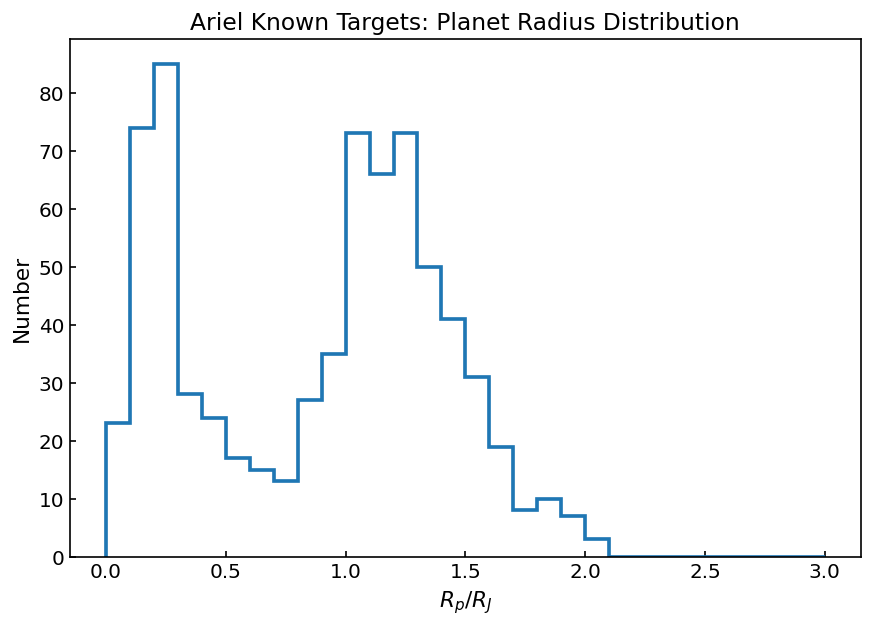

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def rp_over_rj_histogram(
    df,
    out_path="ariel_known_Rp_Rj_hist.pdf",
    rj_max=3,
    bin_width=0.1,
):
    # Convert Rp to R_J
    rp_re = pd.to_numeric(df["Planet Radius [Re]"], errors="coerce").to_numpy(float)
    rp_re = rp_re[np.isfinite(rp_re) & (rp_re > 0)]

    R_EARTH_PER_R_JUP = 11.209
    rp_rj = rp_re / R_EARTH_PER_R_JUP

    # bins in Rp/Rj
    bins = np.arange(0, rj_max + bin_width, bin_width)

    plt.figure(figsize=(8.5, 5.6))
    plt.hist(rp_rj[rp_rj < rj_max],
             bins=bins,
             histtype="step",
             linewidth=2.2)

    plt.xlabel(r"$R_p / R_J$")
    plt.ylabel("Number")
    plt.title("Ariel Known Targets: Planet Radius Distribution")

    plt.grid(True, axis="y", alpha=0.25)
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(False)
    # annotations
    n_total = rp_rj.size
    n_big = np.sum(rp_rj >= rj_max)

    plt.gca.text(
    0.98, 0.92, "N = 722",
    transform=plt.gca.transAxes,
    ha="right", va="top",
    fontsize=13)

    if n_big > 0:
        plt.text(0.02, 0.84,
                 f"{n_big} planets with $R_p / R_J \\ge {rj_max}$ not shown",
                 transform=plt.gca().transAxes,
                 fontsize=11)

    plt.tight_layout()
    plt.savefig(out_path, dpi=250, bbox_inches="tight")
    plt.close()

    print("Saved:", out_path)


# usage
df = pd.read_csv("Ariel_MCS_Known_2024-07-09.csv")
rp_over_rj_histogram(df)
